In class, we learned that the narrow-resonance approximation leads to a slowing-down flux spectrum of the form

$$
  \phi_{NR}(E) = \frac{1}{E \Sigma_t(E)} \, ,
$$

where $\Sigma_t(E)$ is the macroscopic, total cross section for a homogeneous material.

Let's compute the narrow-resonance spectrum for our UO2/water mix defined in [InfiniteMediumMaterials](InfiniteMediumMaterials.ipynb).   First, let's load the materials from the generated XML file:

In [1]:
import openmc
import numpy as np
import os

In [2]:
materials = openmc.Materials.from_xml(); # must have materials.xml defined!

Extract the `uo2_water` material and inspect its composition:

In [3]:
uo2_water = materials[2]

In [4]:
uo2_water.nuclides

[NuclideTuple(name='U235', percent=0.005400716699057935, percent_type='ao'),
 NuclideTuple(name='U238', percent=0.12797998450734668, percent_type='ao'),
 NuclideTuple(name='O16', percent=0.4668072483889763, percent_type='ao'),
 NuclideTuple(name='H1', percent=0.39981205040461903, percent_type='ao')]

Each nuclide in the mixture has a `name` that corresponds to the HDF5 file that contains the data.  In addition, the atom fraction for each nuclide is given.  Hence, to compute the total cross section requires that we loop over these nuclides, open the cross section file, and extract the data as shown in [ViewingCrossSections](ViewingCrossSections.ipynb).  Here, we'll load only the 294K values.  Note, the *total* cross section is the sum of all the reactions for MT=2 through MT=117.  For most nuclides, the majority of the total cross section comes from elastic scattering (MT=2), capture (MT=102), and fission (MT=18), so we'll approximate the total cross section using those reactions.

In [5]:
xspath = ""
try:
    xspath = os.environ['OPENMC_CROSS_SECTIONS']
    xspath = xspath[:xspath.index('cross_sections.xml')]
except:
    print("Make sure OPENMC_CROSS_SECTIONS is defined!")

In [6]:
data = {}
for i in range(len(uo2_water.nuclides)):
    nucl = uo2_water.nuclides[i]
    # load HDF5
    file = openmc.data.IncidentNeutron.from_hdf5(xspath+nucl.name+".h5")
    # Extract energies and sigmas
    E = file[2].xs['294K'].x
    sigT = file[2].xs['294K'].y
    if 18 in file: # some nuclides have no fission data
        sigT += file[18].xs['294K'].y
    sigT += file[102].xs['294K'].y
    data[nucl.name] = {}
    data[nucl.name]['E'] = E
    data[nucl.name]['sigT'] = sigT

Now, we need to choose an energy grid on which to define all the cross sections:

In [7]:
E = np.logspace(-3, 7, 50000)

Then, we loop through the nuclides, interpolate the microscopic total cross section on the energy grid, multiply the result by the atomic fraction, and add that to the macroscopic cross section. Using the atomic fraction here is just fine since the total cross section would scale with the overall material mass density.

In [8]:
SigT = np.zeros_like(E)
for nucl in uo2_water.nuclides:
    atomic_percent = nucl.percent
    SigT += np.interp(E, data[nucl.name]['E'], data[nucl.name]['sigT'])

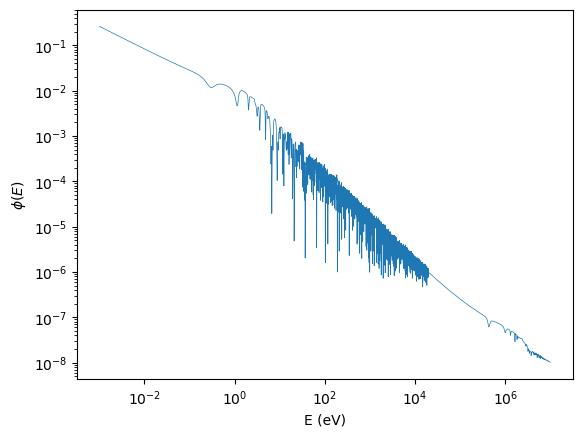

In [11]:
import matplotlib.pyplot as plt
phi_NR = 1/(E*SigT)
plt.loglog(E, phi_NR, lw=0.5)

plt.xlabel('E (eV)')
plt.ylabel('$\phi(E)$');

np.save('nr_flux.npy', phi_NR)